*Нам предстоит предсказать цену аренды квартиры на основе содержимого объявления, такого как текстовое описание, фотографии, количество спален, цена и другие параметры. Данные взяты с renthop.com, сайта с объявлениями о сдаче квартир*

# **1. Введение**

В этом проекте необходимо определить, насколько популярным будет предложение о сдаче квартиры в аренду, основываясь на содержании объявления, таком как текстовое описание, фотографии, количество спален, цена и т.д. Данные взяты с сайта объявлений о продаже квартир renthop.com. Эти апартаменты расположены в Нью-Йорке.

Целевая переменная interest_level определяется количеством запросов, поступивших к объявлению за время его нахождения на сайте.

# **2. Вводный анализ данных**

## Иморт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import scipy
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from zipfile import ZipFile
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

Чтение файла из моего гугл диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with ZipFile('/content/drive/MyDrive/two-sigma-connect-rental-listing-inquiries (1).zip', 'r') as f:
  f.extractall('/content/sample_data')

In [ ]:
train_data = pd.read_json('/content/sample_data/train.json.zip', compression='zip')
train_data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


1. Size of data

In [ ]:
df = pd.DataFrame.from_dict(train_data)
df.size

740280

2. Print the list of columns. Which column is a target?

In [ ]:
list(df.columns.values )

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level']

3. Quick analysis of the data: use the methods info(), describe(), corr().

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 7.0+ MB


Датасет содержит 49352 строк и 15 признаков, из которых 6 - числовые. Целевым признаком (меткой) является price

## Описательная статистика

In [ ]:
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [ ]:
df[['bathrooms', 'bedrooms', 'latitude','listing_id', 'longitude', 'price' ]].corr()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
bathrooms,1.000000,0.533446,-0.009657,0.000776,0.010393,0.069661
bedrooms,0.533446,1.000000,-0.004745,0.011968,0.006892,0.051788
latitude,-0.009657,-0.004745,1.000000,0.001712,-0.966807,-0.000707
listing_id,0.000776,0.011968,0.001712,1.000000,-0.000907,0.008090
longitude,0.010393,0.006892,-0.966807,-0.000907,1.000000,-0.000087
price,0.069661,0.051788,-0.000707,0.008090,-0.000087,1.000000


Количество ванн и спален наиболее коррелирует с ценой

In [ ]:
df = df[['bathrooms',
        'bedrooms',
         'price',
        'interest_level']].reset_index()
df

,index,bathrooms,bedrooms,price,interest_level
0,4,1.0,1,2400,medium
1,6,1.0,2,3800,low
2,9,1.0,2,3495,medium
3,10,1.5,3,3000,medium
4,15,1.0,0,2795,low
...,...,...,...,...,...
49347,124000,1.0,3,2800,low
49348,124002,1.0,2,2395,medium
49349,124004,1.0,1,1850,medium
49350,124008,1.0,2,4195,medium


# 3.Статистический анализ данных

## 3.1 Теория по статистике

## 3.2 Методы визуализации

## 3.3 Целевой анализ

1. Plot a histogram to understand the distribution of the target. Is it all clear?

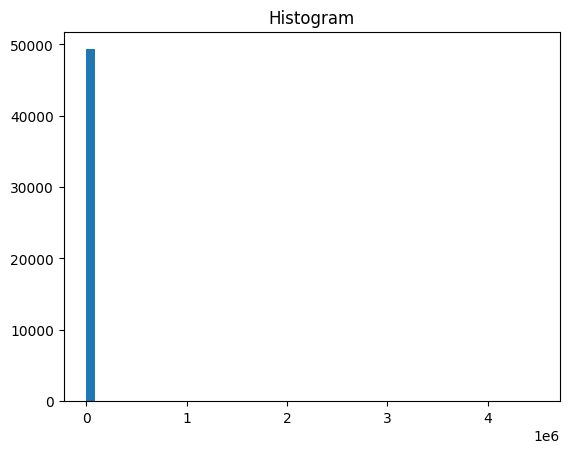

In [ ]:
plt.hist(df['price'], bins = 50)
plt.title("Histogram")
plt.show()

Данная гистограма не информативна

The next step is boxplot(). What can you say about the target? Are there any outliers?

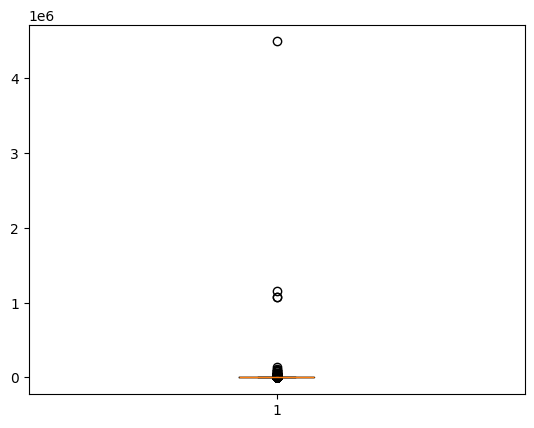

In [ ]:
plt.boxplot(df['price'])
plt.show()

Данная диаграмма также не информативна. Очень большие выбросы

Drop the rows that are outside the 1 and 99 percentiles from the target column.

In [ ]:
low_perc_quant = df['price'].quantile(0.01)
high_perc_quant = df['price'].quantile(0.99)
df = df[(df['price'] > low_perc_quant) & (df['price'] < high_perc_quant)]
df

,index,bathrooms,bedrooms,price,interest_level
0,4,1.0,1,2400,medium
1,6,1.0,2,3800,low
2,9,1.0,2,3495,medium
3,10,1.5,3,3000,medium
4,15,1.0,0,2795,low
...,...,...,...,...,...
49347,124000,1.0,3,2800,low
49348,124002,1.0,2,2395,medium
49349,124004,1.0,1,1850,medium
49350,124008,1.0,2,4195,medium


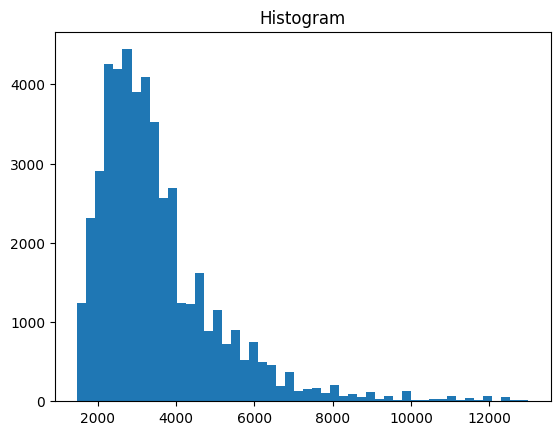

In [ ]:
plt.hist(df['price'], bins = 50)
plt.title("Histogram")
plt.show()

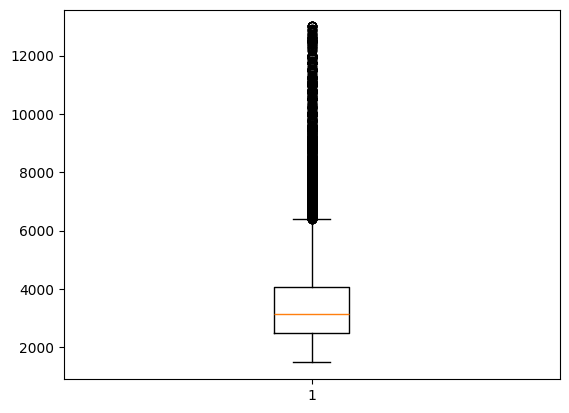

In [ ]:
plt.boxplot(df['price'])
plt.show()

Теперь и гистограмма и ящик с усами стали понятнее

## 3.4 Анализ характеристик

Определим тип признака 'interest_level'

In [ ]:
print(df['interest_level'].dtypes)

object


In [ ]:
df['interest_level']

,interest_level
0,medium
1,low
2,medium
3,medium
4,low
...,...
49347,low
49348,medium
49349,medium
49350,medium


In [ ]:
df['interest_level'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [ ]:
num_interest_level = {
    'low' : 0,
    'medium' : 1,
    'high' : 2
}

df['interest_level'] = df['interest_level'].map(num_interest_level)
df

<ipython-input-185-e301d08270f5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interest_level'] = df['interest_level'].map(num_interest_level)


,index,bathrooms,bedrooms,price,interest_level
0,4,1.0,1,2400,1
1,6,1.0,2,3800,0
2,9,1.0,2,3495,1
3,10,1.5,3,3000,1
4,15,1.0,0,2795,0
...,...,...,...,...,...
49347,124000,1.0,3,2800,0
49348,124002,1.0,2,2395,1
49349,124004,1.0,1,1850,1
49350,124008,1.0,2,4195,1


Text(0, 0.5, 'Количество спальных комнат')

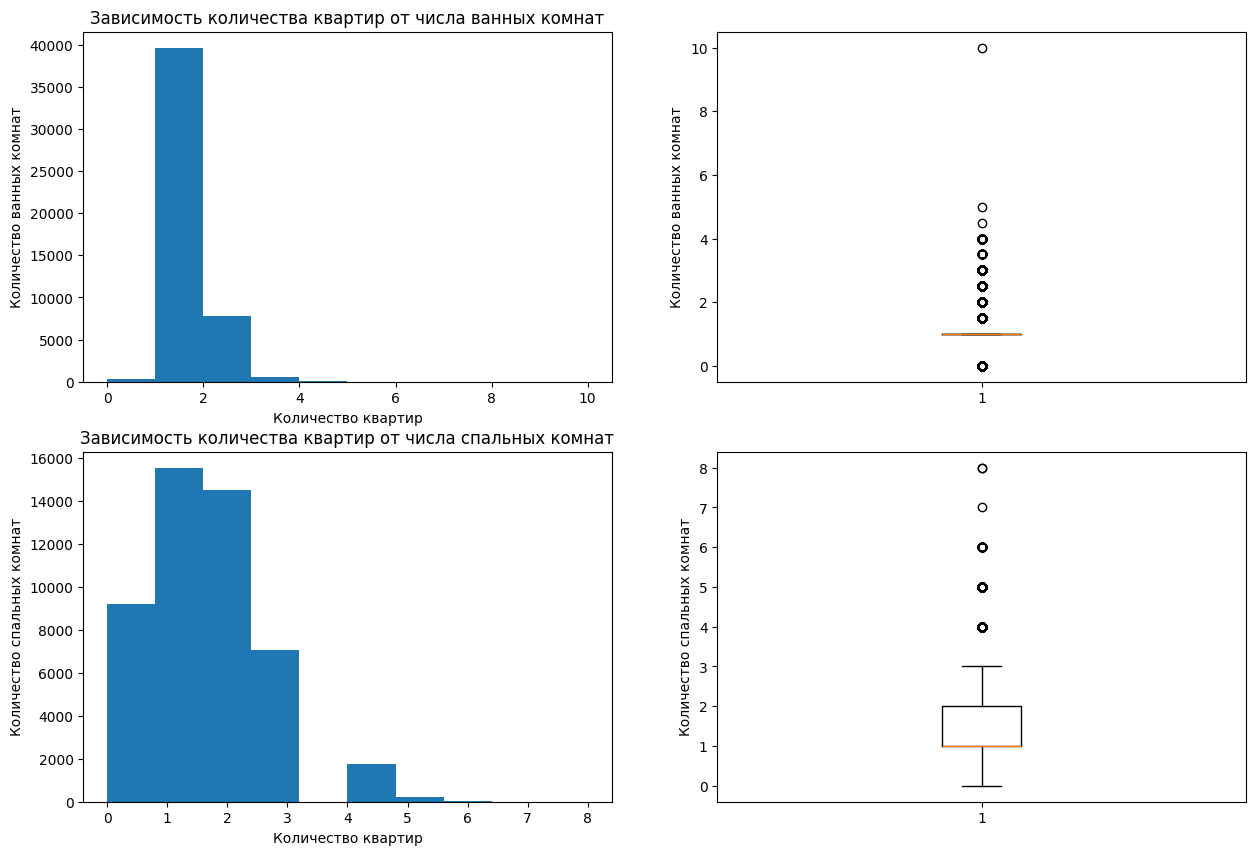

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.hist(df['bathrooms'])
plt.title('Зависимость количества квартир от числа ванных комнат')
plt.xlabel('Количество квартир')
plt.ylabel('Количество ванных комнат')

plt.subplot(2, 2, 2)
plt.boxplot(df['bathrooms'])
plt.ylabel('Количество ванных комнат')

plt.subplot(2, 2, 3)
plt.hist(df['bedrooms'])
plt.title('Зависимость количества квартир от числа спальных комнат')
plt.xlabel('Количество квартир')
plt.ylabel('Количество спальных комнат')

plt.subplot(2, 2, 4)
plt.boxplot(df['bedrooms'])
plt.ylabel('Количество спальных комнат')

## 3.5 Комплексный анализ

Постройте корреляционную матрицу, чтобы понять взаимосвязь между объектами и целью. Постройте тепловую карту для корреляционной матрицы. Есть ли корреляция?

In [ ]:
corr_matrix = df[['bathrooms', 'bedrooms', 'interest_level', 'price' ]].corr()
corr_matrix

,bathrooms,bedrooms,interest_level,price
bathrooms,1.000000,0.517200,-0.062819,0.670808
bedrooms,0.517200,1.000000,0.051282,0.547310
interest_level,-0.062819,0.051282,1.000000,-0.199652
price,0.670808,0.547310,-0.199652,1.000000


<Axes: >

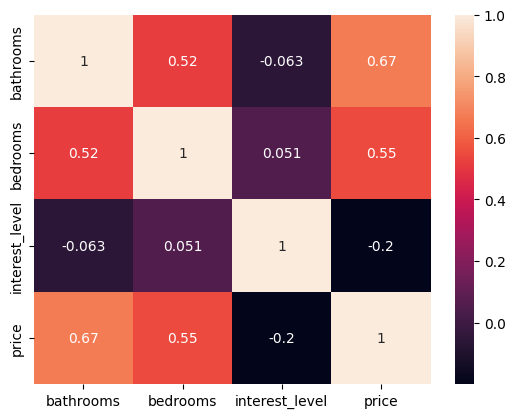

In [ ]:
sns.heatmap(corr_matrix, annot=True)

Количество ванных и спальных комнат наиболее сильно коррелируют с ценой квартир.

Text(0, 0.5, 'interest_level')

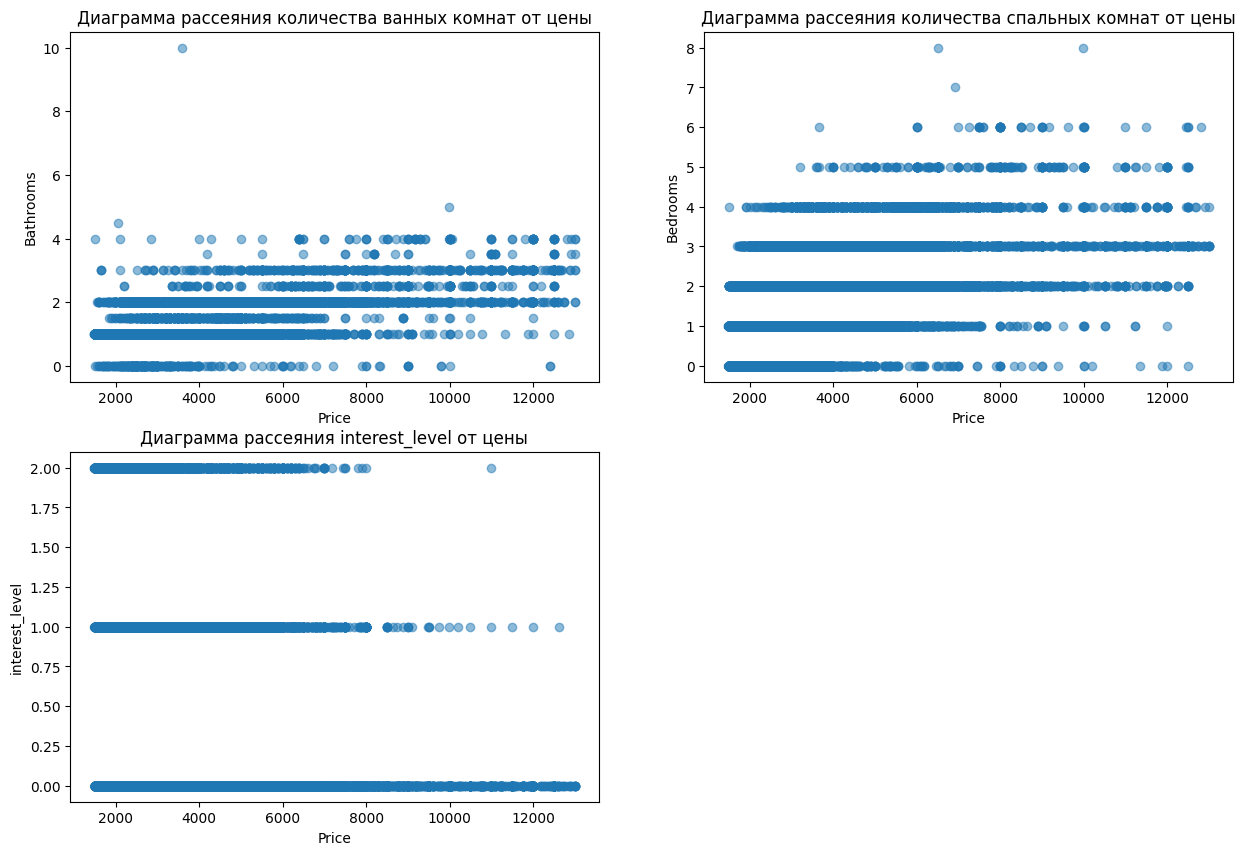

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.scatter(df['price'], df['bathrooms'], alpha = 0.5)
plt.title("Диаграмма рассеяния количества ванных комнат от цены")
plt.xlabel("Price")
plt.ylabel("Bathrooms")

plt.subplot(2,2,2)
plt.scatter(df['price'], df['bedrooms'], alpha = 0.5)
plt.title("Диаграмма рассеяния количества спальных комнат от цены")
plt.xlabel("Price")
plt.ylabel("Bedrooms")

plt.subplot(2,2,3)
plt.scatter(df['price'], df['interest_level'], alpha = 0.5)
plt.title("Диаграмма рассеяния interest_level от цены")
plt.xlabel("Price")
plt.ylabel("interest_level")

# 4.Создание новых признаков

In [ ]:
df_new_features = df.copy()
df_new_features['bathrooms_squared'] = df['bathrooms'] ** 2
df_new_features['bedrooms_squared'] = df['bedrooms'] ** 2
df_new_features['interest_level_squared'] = df['interest_level'] ** 2
df_new_features['bathrooms*bedrooms'] = df['bathrooms'] * df['bedrooms']

In [ ]:
corr_matrix = df_new_features[['bathrooms', 'bedrooms', 'interest_level',
                               'bathrooms_squared', 'bedrooms_squared', 'interest_level_squared',
                               'bathrooms*bedrooms',
                               'price']].corr()
corr_matrix

,bathrooms,bedrooms,interest_level,bathrooms_squared,bedrooms_squared,interest_level_squared,bathrooms*bedrooms,price
bathrooms,1.000000,0.517200,-0.062819,0.955906,0.548426,-0.058710,0.843636,0.670808
bedrooms,0.517200,1.000000,0.051282,0.478497,0.928282,0.040125,0.853769,0.547310
interest_level,-0.062819,0.051282,1.000000,-0.067757,0.047048,0.943959,-0.006360,-0.199652
bathrooms_squared,0.955906,0.478497,-0.067757,1.000000,0.521951,-0.061563,0.823193,0.646949
bedrooms_squared,0.548426,0.928282,0.047048,0.521951,1.000000,0.036408,0.882100,0.544612
interest_level_squared,-0.058710,0.040125,0.943959,-0.061563,0.036408,1.000000,-0.010242,-0.182283
bathrooms*bedrooms,0.843636,0.853769,-0.006360,0.823193,0.882100,-0.010242,1.000000,0.683346
price,0.670808,0.547310,-0.199652,0.646949,0.544612,-0.182283,0.683346,1.000000


Новые признаки не показали большей корреляции. Поэтому в обучении моделей их использовать не буду.

<Axes: >

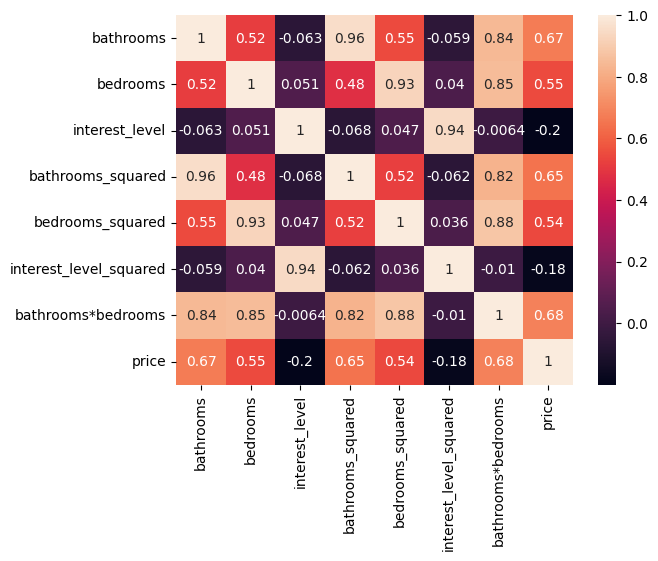

In [ ]:
sns.heatmap(corr_matrix, annot=True)

- Разделение данных на тестовую и тренировочную выборку

In [ ]:
X = df[['bathrooms', 'bedrooms', 'interest_level']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [ ]:
poly = sklearn.preprocessing.PolynomialFeatures(degree=10)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

# 5.Обучение моделей

## 5.1 Таблицы с результатами


- Создам две таблицы для хранения результатов расчетов RMSE и MAE со столбцами  'model', 'train', 'test'. Эти таблицы заполню результатами по обучению моделей

In [ ]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])

## 5.2 Линейная регрессия

In [ ]:
model = LinearRegression()

Обучение модели и предсказание

In [ ]:
model.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
y_train_predict = model.predict(X_train_poly)
y_test_predict = model.predict(X_test_poly)

Расчет MAE и RMSE

In [ ]:
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)

In [ ]:
rmse_train = root_mean_squared_error(y_train, y_train_predict)
rmse_test = root_mean_squared_error(y_test, y_test_predict)

In [ ]:
result_MAE.loc[len(result_MAE.index)] = ['linear_regression', mae_train, mae_test]
result_MAE

,model,train,test
0,linear_regression,718.833481,1249.726459


In [ ]:
result_RMSE.loc[len(result_RMSE.index)] = ['linear_regression', rmse_train, rmse_test]
result_RMSE

,model,train,test
0,linear_regression,1025.592951,51089.568025


## 5.3 Дерево решений

In [ ]:
model = DecisionTreeRegressor(random_state = 21)

In [ ]:
model.fit(X_train_poly, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
y_train_predict = model.predict(X_train_poly)
y_test_predict = model.predict(X_test_poly)

- Расчет MAE и RMSE


In [ ]:
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)

In [ ]:
rmse_train = root_mean_squared_error(y_train, y_train_predict)
rmse_test = root_mean_squared_error(y_test, y_test_predict)

In [ ]:
result_MAE.loc[len(result_MAE.index)] = ['decision_tree', mae_train, mae_test]
result_MAE

,model,train,test
0,linear_regression,718.833481,1249.726459
1,decision_tree,718.825041,727.070811


In [ ]:
result_RMSE.loc[len(result_RMSE.index)] = ['decision_tree', rmse_train, rmse_test]
result_RMSE

,model,train,test
0,linear_regression,1025.592951,51089.568025
1,decision_tree,1025.483464,1032.541333


## 5.4 Нативные модели

 - Calculate the mean and median of 'price' on the training and test data and create a column with these values.

In [ ]:
native_train = pd.DataFrame(data=y_train)
native_train['mean'] = native_train['price'].mean()
native_train['median'] = native_train['price'].median()
native_train

,price,mean,median
44088,3200,3535.823783,3150.0
26961,4650,3535.823783,3150.0
39739,5000,3535.823783,3150.0
3836,5500,3535.823783,3150.0
19524,2350,3535.823783,3150.0
...,...,...,...
16779,3750,3535.823783,3150.0
9165,7000,3535.823783,3150.0
6080,3800,3535.823783,3150.0
5454,2895,3535.823783,3150.0


In [ ]:
native_test = pd.DataFrame(data=y_test)
native_test['mean'] = native_test['price'].mean()
native_test['median'] = native_test['price'].median()
native_test

,price,mean,median
15316,2650,3532.541111,3147.0
29020,4000,3532.541111,3147.0
16422,3715,3532.541111,3147.0
33071,4700,3532.541111,3147.0
20415,10680,3532.541111,3147.0
...,...,...,...
46375,5500,3532.541111,3147.0
13009,2900,3532.541111,3147.0
4297,2600,3532.541111,3147.0
20420,2050,3532.541111,3147.0


In [ ]:
mae_mean_train = mean_absolute_error(y_train, native_train['mean'])
mae_mean_test = mean_absolute_error(y_test, native_test['mean'])

In [ ]:
mae_med_train = mean_absolute_error(y_train, native_train['median'])
mae_med_test = mean_absolute_error(y_test, native_test['median'])

In [ ]:
rmse_mean_train = root_mean_squared_error(y_train, native_train['mean'])
rmse_mean_test = root_mean_squared_error(y_test, native_test['mean'])

rmse_med_train = root_mean_squared_error(y_train, native_train['median'])
rmse_med_test = root_mean_squared_error(y_test, native_test['median'])

In [ ]:
result_MAE.loc[len(result_MAE.index)] = ['native_mean', mae_mean_train, mae_mean_test]
result_MAE.loc[len(result_MAE.index)] = ['native_median', mae_med_train, mae_med_test]
result_MAE

,model,train,test
0,linear_regression,718.833481,1249.726459
1,decision_tree,718.825041,727.070811
2,native_mean,1131.815443,1144.533690
3,native_median,1079.734162,1092.166408


In [ ]:
result_RMSE.loc[len(result_RMSE.index)] = ['native_mean', rmse_mean_train, rmse_mean_test]
result_RMSE.loc[len(result_RMSE.index)] = ['native_median', rmse_med_train, rmse_med_test]
result_RMSE

,model,train,test
0,linear_regression,1025.592951,51089.568025
1,decision_tree,1025.483464,1032.541333
2,native_mean,1580.460676,1606.034024
3,native_median,1626.873056,1651.661962


## 5.5 Сравнение результатов

In [ ]:
result_MAE

,model,train,test
0,linear_regression,718.833481,1249.726459
1,decision_tree,718.825041,727.070811
2,native_mean,1131.815443,1144.533690
3,native_median,1079.734162,1092.166408


In [ ]:
result_RMSE

,model,train,test
0,linear_regression,1025.592951,51089.568025
1,decision_tree,1025.483464,1032.541333
2,native_mean,1580.460676,1606.034024
3,native_median,1626.873056,1651.661962


**Определим лучшую модель**

Лучшие показатели:

*по MAE:*

    train: decision_tree 🌳

    test: decision_tree 🌳

*по RMSE:*


    train: decision_tree 🌳

    test: decision_tree 🌳

Вывод: Наилучший результат показала модель Decision Tree